## Hello IPython Notebook World!
I've actually never used IPython before. I downloaded Anaconda when I first started learning Python about a year ago, and never felt the need to try anything new, since I usually only do data processing in Python and analysis using R. However, I read somewhere that the IPython Notebook was similar to knitr, a tool I have been loving since I discovered it, so I have been wanting to try it out myself. Also, I want to start using Python more for analysis because I've always favored R and I don't think I gave Python a fair chance. My goal is to understand the advantages of both languages and be able to work in the one that better suits the task at hand!

Below I am going to redo a data challenge that was sent to me a few weeks ago. The dataset was given to me in the form of a SQLite database. The goal of the assignment was to find evidence of a behavior change, if any. A hint was to look at the rate of change in one particular variable (quotes) over time. I will be using **pymc**, **numpy**, **pandas** and **matplotlib** to answer the prompt.

First, we load in the 6 tables from the database and take a peek at the information it holds.  

In [1]:
import os 
import sqlite3
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import pymc as pm 
os.chdir("C:/Users/MelodyYin/Desktop")

conn = sqlite3.connect('invite_dataset.sqlite')

def fetch(tbl_nm):
    return pd.read_sql_query("SELECT * FROM "+tbl_nm, conn)

categories = fetch("categories")
locations = fetch("locations")
users = fetch("users")
requests = fetch("requests")
invites = fetch("invites")
quotes = fetch("quotes")

In [2]:
requests.head()

,request_id,user_id,category_id,location_id,creation_time
0,1,1001,46,35,2013-07-01 07:48:54.000000
1,2,1002,83,19,2013-07-01 04:55:25.000000
2,3,1003,63,91,2013-07-01 09:34:53.000000
3,4,1004,56,2,2013-07-01 10:16:40.000000
4,5,1005,64,11,2013-07-01 03:45:47.000000


In [3]:
invites.head()

,invite_id,request_id,user_id,sent_time
0,1,1,312,2013-07-01 13:20:05.072029
1,2,1,850,2013-07-01 15:49:33.110849
2,3,1,555,2013-07-01 13:39:18.608330
3,4,1,917,2013-07-01 08:56:11.751781
4,5,1,215,2013-07-01 08:40:24.151670


In [4]:
quotes.head()

,quote_id,invite_id,sent_time
0,1,4,2013-07-01 11:04:44.204874
1,2,5,2013-07-01 10:39:30.083032
2,3,6,2013-07-01 16:43:37.668191
3,4,8,2013-07-01 22:10:35.168437
4,5,9,2013-07-01 13:02:03.174618


Since we know we will be dealing with changes over time, we should parse the `time` columns.

In [5]:
requests['creation_time'] = pd.to_datetime(requests['creation_time'])
invites['sent_time'] = pd.to_datetime(invites['sent_time'])
quotes['sent_time'] = pd.to_datetime(quotes['sent_time'])

One simple thing we can do to start off with is look at the quote behavior over time. 

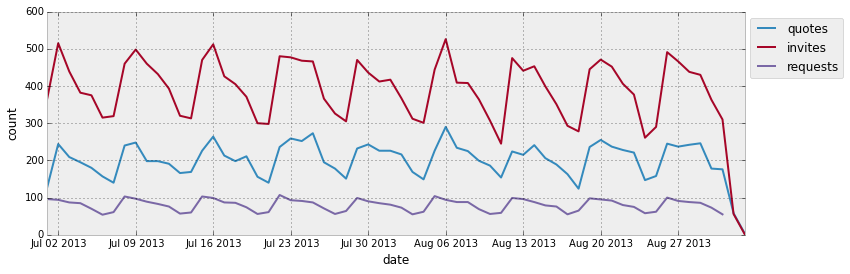

In [6]:
q_dts = quotes['sent_time'].map(lambda x: x.date())
i_dts = invites['sent_time'].map(lambda x: x.date())
r_dts = requests['creation_time'].map(lambda x: x.date())

figsize(12.5, 4)
q_dts.groupby(q_dts).count().plot(label="quotes")
i_dts.groupby(i_dts).count().plot(label="invites")
r_dts.groupby(r_dts).count().plot(label="requests")
plt.legend(bbox_to_anchor=(1.15,1))
plt.xlabel("date")
plt.ylabel("count")

There seems to be a consistent, reliable pattern throughout the week in requests, invites and quotes sent. Notice that there are many more invites sent than requests or quotes received. This makes sense because not all invites are responded to, and each consumer ideally will get multiple quotes. We can also repeat this process for time of day.

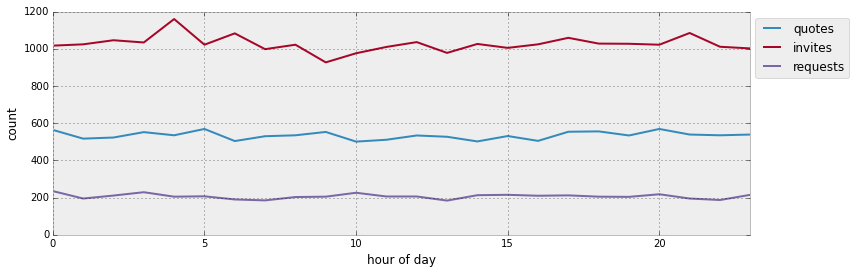

In [7]:
q_hrs = quotes['sent_time'].map(lambda x: x.hour)
i_hrs = invites['sent_time'].map(lambda x: x.hour)
r_hrs = requests['creation_time'].map(lambda x: x.hour)

q_hrs.groupby(q_hrs).count().plot(label="quotes")
i_hrs.groupby(i_hrs).count().plot(label="invites")
r_hrs.groupby(r_hrs).count().plot(label="requests")
plt.legend(bbox_to_anchor=(1.15,1))
plt.xlabel("hour of day")
plt.ylabel("count")

Again, there doesn't seem to be anything noteworthy. It is odd that there are just as many requests and quotes created between the hours of midnight - 5AM as there is any other block, but the dataset is artificial. 

Next, we derive the invite-to-quote rate over time. Similarly, we will see how the rate per day fluctuates over the two months. Just as a sanity check for later, we can use the average invite-to-quote rate.

In [8]:
invites['invite_id'].count() / float(quotes['quote_id'].count())

1.9207426476324205

On average, there are about 2 invites sent per quote received. 

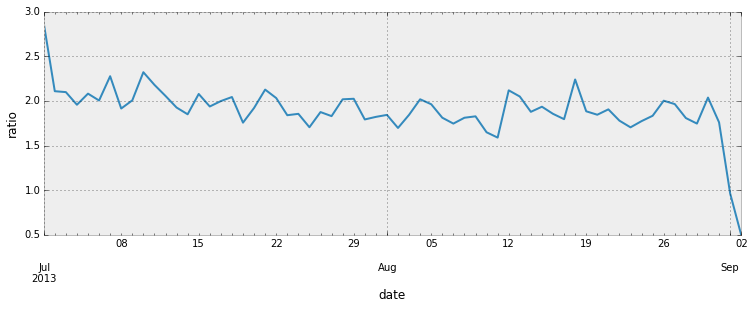

In [9]:
quotes['date'] = q_dts.apply(lambda x: x.strftime('%Y%m%d')) # can't do count() on datetime 
invites['date'] = i_dts.apply(lambda x: x.strftime('%Y%m%d'))
qc = quotes[['date', 'quote_id']].groupby('date', as_index=False).count()
ic = invites[['date', 'invite_id']].groupby('date', as_index=False).count() 
i2q = pd.merge(qc, ic, on='date')
i2q['ratio'] = i2q['invite_id'] / i2q['quote_id']
i2q['date'] = pd.to_datetime(i2q['date'], format='%Y%m%d')
i2q[['date', 'ratio']].plot(x='date', y='ratio', kind='line')
plt.xlabel("date")
plt.ylabel("ratio")

I think the drops in ratio from the beginning and end of the time period is probably due to incomplete data.

In [10]:
i2q.query('date >= "2013-08-31" or date <= "2013-07-02"')

,date,quote_id,invite_id,ratio
0,2013-07-01,127,365,2.874016
1,2013-07-02,244,515,2.110656
61,2013-08-31,176,310,1.761364
62,2013-09-01,58,56,0.965517
63,2013-09-02,4,2,0.500000


It looks like rows 0, 62 and 63 can be removed. 

In [11]:
if len(i2q) == 64: 
    i2q = i2q.drop([0,62,63])

We saw that the sample sizes were pretty consistent in the first graph, and we assume that activity by category and location is not dependent on which day it is, so there is no need to standardize the ratios for now. Let's take another look at the ratio trend after the 3 rows have been dropped.

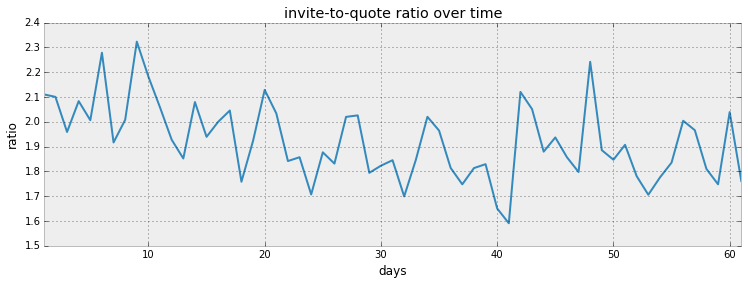

In [12]:
i2q['ratio'].plot()
plt.title("invite-to-quote ratio over time")
plt.xlabel("days")
plt.ylabel("ratio")

Whereas before there were no obvious trends, we can see now that the ratio slopes downward until day 40, when it seems to rise back up and gain some stability. We can test this hypothesis using a model with 2 distributions and finding the parameters using Bayesian estimation. To start, we convert the dates to days since the beginning of July (specifically, July 2nd). We then choose uniform distributions as the priors for the means, and gamma distribution as the prior for the precision. The day of change should be modeled by another uniform (but discrete) variable. Observations should be Normal. 

In [13]:
mean_1 = pm.Uniform("mean_1", lower=1, upper=3)
mean_2 = pm.Uniform("mean_2", lower=1, upper=3)
tau = pm.DiscreteUniform("tau", lower=1, upper=61)

@pm.deterministic
def mean_(tau=tau, mean_1=mean_1, mean_2=mean_2):
    out = np.zeros(len(i2q['ratio']))
    out[:tau] = mean_1
    out[tau:] = mean_2
    return out

precision = pm.Gamma("precision", alpha=0.1, beta=0.1)
observations = pm.Normal("obs", mean_, precision, value=i2q['ratio'], observed=True)

model = pm.Model([mean_1, mean_2, tau, precision, observations])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 14.8 sec

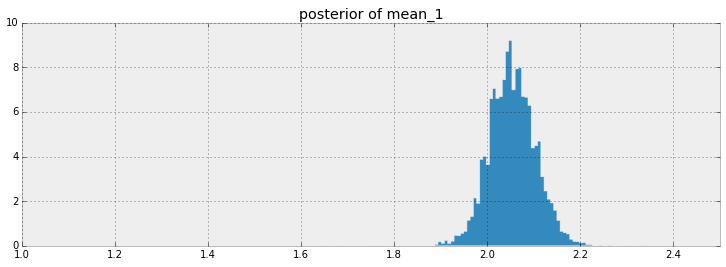

In [14]:
mean_1_samples = mcmc.trace('mean_1')[:]
mean_2_samples = mcmc.trace('mean_2')[:]
tau_samples = mcmc.trace('tau')[:]

plt.hist(mean_1_samples, bins=100, histtype='stepfilled', normed=True);
plt.xlim(1, 2.5)
plt.title("posterior of mean_1")

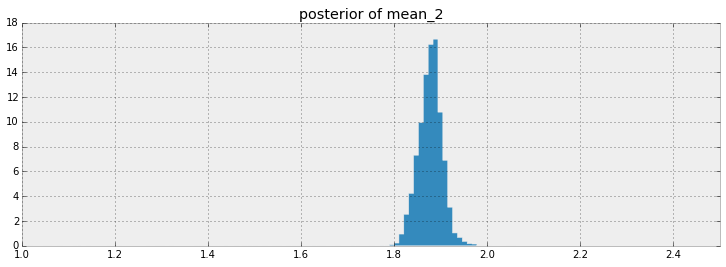

In [15]:
plt.hist(mean_2_samples, bins=100, histtype='stepfilled', normed=True);
plt.xlim(1, 2.5)
plt.title("posterior of mean_2")

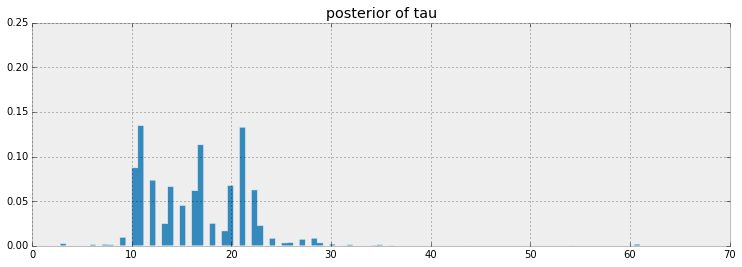

In [16]:
w = np.ones_like(tau_samples) / float(len(tau_samples))
plt.hist(tau_samples, bins=100, histtype='stepfilled', weights=w);
plt.ylim(0,0.25)
plt.title("posterior of tau")

From the resulting posterior distributions, we can see that the estimates for mean_1 is around 1.9 and for mean_2, it is around 2.1, which is a small difference. The curves are also wide (a consequence of the low number of observations), suggesting that the posterior estimate is uncertain. Simiarly, the posterior for tau is also spread out; the most likely days of change are around day 11 and 21, but the probability is low. In other words, no single day stands out as being the best candidate for tau. If there indeed was a change, we would expect one day to have much higher probability than the rest. 

In summary, I believe the patterns in the posterior plots indicate that there was no change in the invite-to-quote rate in the provided time period. 

## Validation
If our conclusion is correct, then we should be able to generate data similar to our observations using samples from the posterior with a single distribution.

In [17]:
sims = pm.Normal("sims", mean_1, precision)

In [18]:
model = pm.Model([sims, mean_1, precision, observations])
mcmc = pm.MCMC(model)
mcmc.sample(10183, 10000, 1)

 [-----------------100%-----------------] 10183 of 10183 complete in 3.1 sec

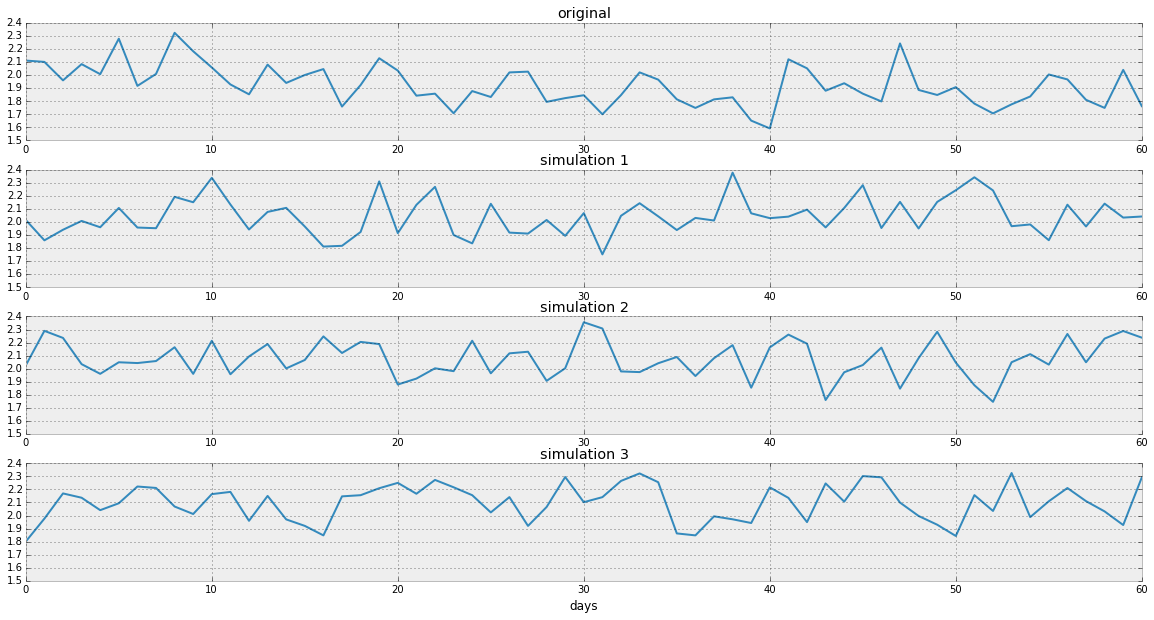

In [19]:
simulations = mcmc.trace("sims")[:]

figsize(20, 10)

plt.subplot(4,1,1)
plt.subplots_adjust(hspace=.25)
plt.plot(i2q['ratio'])
plt.title("original")

plt.subplot(4,1,2)
plt.plot(simulations[:61])
plt.title("simulation 1")
plt.ylim(1.5, 2.4)

plt.subplot(4,1,3)
plt.plot(simulations[61:122])
plt.title("simulation 2")
plt.ylim(1.5, 2.4)

plt.subplot(4,1,4)
plt.plot(simulations[122:183])
plt.title("simulation 3")
plt.ylim(1.5, 2.4)
plt.xlabel("days")

The simulated data look very similar to the original, so we can be confident about our model

## Conclusion
Overall, there was not sufficient evidence to conclude that product changes had a change in site-wide quote behavior in the past two months. Additional tests are needed once more data from the next few months can be obtained. This could be because users and service providers are still adjusting to the new product changes, a process which may take several days or weeks, depending on the magnitude of the change. 